# Introduction to Regression Discontinuity Design

Code and data taken from: https://github.com/natematias/research_in_python/blob/master/regression_discontinuity/Regression%20Discontinuity%20Analysis.ipynb

**Regression Discontinuity** is a method that makes use of a treatment applied at a cutoff point. It takes advantage of the fact that subjects at either side of the cutoff are not likely to substantially differ from one another on confounders. Thus, any difference in outcomes are only attributable to the intervention itself.

In this notebook, we will learn how to implement and visualize a RDD design. We are using data from Joshua Angrist and Victor Lavy's "Using Maimonides Rule to Estimate the Effect of Class Size on Scholastic Achievement." A common question in education and social science research is whether class size has an effect on student performance. At both the K-12 and university level, propnents of smaller class sizes argue that large class sizes cause teachers to divide their time and attention too thinly, and students suffer from the lack of individual attention. Moreover, large class sizes might be more distracting and impede student comprehension and achievement in a number of other ways.

In this study, Angrist and Lavy make use of the fact that Israel implemented a rule that automatically split classes if they had more than 40 students. They compared student outcomes for students who were in classes with slightly fewer than 40 students to students who were in classes that were just barely split up. 

In this analysis, we examine a dataset that includes school level data for:

- size: fifth-grade cohort size
- intended_classsize: average intended class size for each school
- observed_classize: observed average class size for each school
- read: average reading achievement in cohort

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf 

In [2]:
# Load data
class_df = pd.read_sas('angrist.sas7bdat')

In [3]:
# Explore the data
class_df.head()

,read,size,intended_classize,observed_classize
0,58.000000,8.0,8.0,8.0
1,82.629997,9.0,9.0,9.0
2,46.330002,9.0,9.0,9.0
3,66.559998,9.0,9.0,11.0
4,75.000000,10.0,10.0,10.0


In [4]:
class_df.describe()

,read,size,intended_classize,observed_classize
count,2019.000000,2019.000000,2019.000000,2019.000000
mean,74.379171,77.741951,30.955935,29.935116
std,7.678460,38.810731,6.107924,6.545885
min,34.799999,8.000000,8.000000,8.000000
25%,69.855000,50.000000,27.000000,26.000000
50%,75.379997,72.000000,31.666666,31.000000
75%,79.839996,100.000000,35.666668,35.000000
max,93.860001,226.000000,40.000000,44.000000


### Question 1: What would be the problem with comparing all students in small classes v. all students in large classes? How might students far away from the cutoff differ in important ways?

## Prepare data for analysis

The key to a regression discontinuity is that we need to distinguish between units that were given treatment, and units that were under control. The usual approach to doing this is to create dummy indicators for whether an observations falls in the pre- or post- side of the intervention.

### Question 2: What is a running variable? How does it relate to the treatment cutoff?

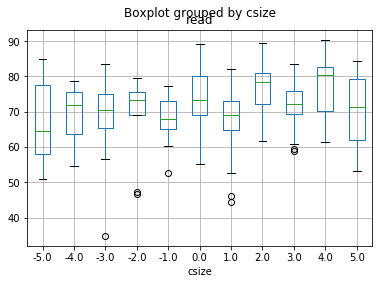

In [5]:
# Write a function that returns a '1' if a class size is large (>40), and a '0' if it is small (<=40)

def small(size):
    if(size >= 41):
        return 1
    return 0

# Create dummy for whether a class size is small, and csize which measures the difference between observed_classize and the cutoff (41)
class_df['small'] = class_df['size'].map(small)
class_df['csize'] = class_df['size'].map(lambda x: x-41)

# summarize the read variable by each class size group
class_df[(class_df['size'] >= 36) & (class_df['size'] <= 46)].boxplot('read', 'csize')

In [9]:
class_df.head()

,read,size,intended_classize,observed_classize,small,csize
0,58.000000,8.0,8.0,8.0,0,-33.0
1,82.629997,9.0,9.0,9.0,0,-32.0
2,46.330002,9.0,9.0,9.0,0,-32.0
3,66.559998,9.0,9.0,11.0,0,-32.0
4,75.000000,10.0,10.0,10.0,0,-31.0


# Regression Discontinuity

Now we're ready to fit a model! Let's narrow the window down to class sizes between 29 and 53, and then estimate the regression.

In [6]:
# Subset the data to size between 29 and 53
window = class_df[(class_df['size'] >= 29) & (class_df['size'] <= 53)]

# Fit OLS model with smf
result = smf.ols(formula = 'read ~ csize + small',
                data = window).fit()

# Print results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   read   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.103
Date:                Tue, 26 Jun 2018   Prob (F-statistic):             0.0459
Time:                        17:37:33   Log-Likelihood:                -1536.6
No. Observations:                 423   AIC:                             3079.
Df Residuals:                     420   BIC:                             3091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.1188      1.151     60.908      0.0

Text(0.5,1,'Regression Discontinuity: Reading Scores by Class Size Before and After the Cutoff')

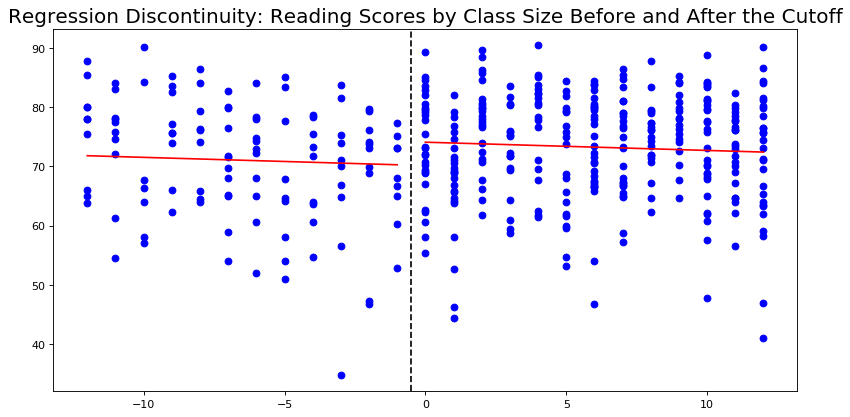

In [7]:
# Plot results with cutoff

plt.figure(num = None, figsize = (12, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.scatter(window.csize, window.read, color = 'blue')
l = window[window.csize < 0].csize.count()
plt.plot(window.csize[0:l], result.predict()[0:l], '-', color = "r")
plt.plot(window.csize[l:], result.predict()[l:], '-', color = "r")
plt.axvline(x = -.5, color = 'black', linestyle = '--')
plt.title("Regression Discontinuity: Reading Scores by Class Size Before and After the Cutoff", fontsize = "18")